# Importing Libraies

In [14]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model           # for getting the summary of our model
import cv2
import torchvision.transforms as T
from tqdm.notebook import trange, tqdm
import torch.optim as optim
import time

In [15]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [16]:
def imshow(title="Image", image=None, size=8):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w / h
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

### Dataset Upload and Explore

Dataset uploaded from Drive or local

# Data Loader 

In [3]:
data_dir = "flowers"
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"
tflow = os.listdir(train_dir)

In [4]:
img_size = 64

Class Types

In [5]:
print(tflow)

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']


In [6]:
print("Total flower classes are: {}".format(len(tflow)))

Total flower classes are: 7


Data distribution

In [7]:
nums = {}
for t in tflow:
    nums[t] = len(os.listdir(train_dir + '/' + t))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
bellflower,1400
daisy,1400
dandelion,1400
lotus,1400
rose,1400
sunflower,1400
tulip,1400


We see that our data is evenly distributed, and we can easily say that there is no trend.

In [8]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 9800 images for training


Transform Compose we are doing some operations like random rotation, horizontal flip to prevent overfitting case.

In [9]:
main_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)), # 32x32
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.25)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.25),
    transforms.RandomErasing()      #randomly erasing pixels 
])

trainx = ImageFolder(train_dir, aug_transform)
testx = ImageFolder(test_dir, main_transform) 

In [10]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + trainx.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

lets look a sample photo. 

Label :bellflower(0)


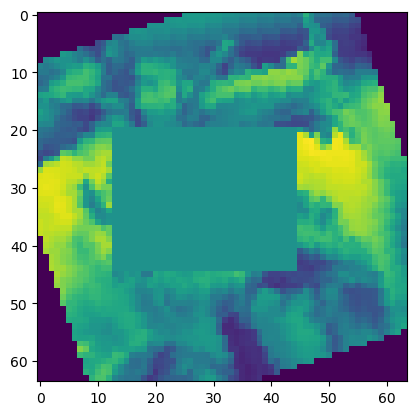

In [11]:
show_image(*trainx[0]) #sample

In [12]:
img, label = trainx[0] #image size checking
print(img.shape, label)

torch.Size([1, 64, 64]) 0


In [13]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [14]:
batch_size = 32

In [15]:
# DataLoaders for training and validation
train_dl = DataLoader(trainx, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(testx, batch_size,  shuffle=True ,num_workers=2, pin_memory=True)

In [16]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

Lets see the look of our batches 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


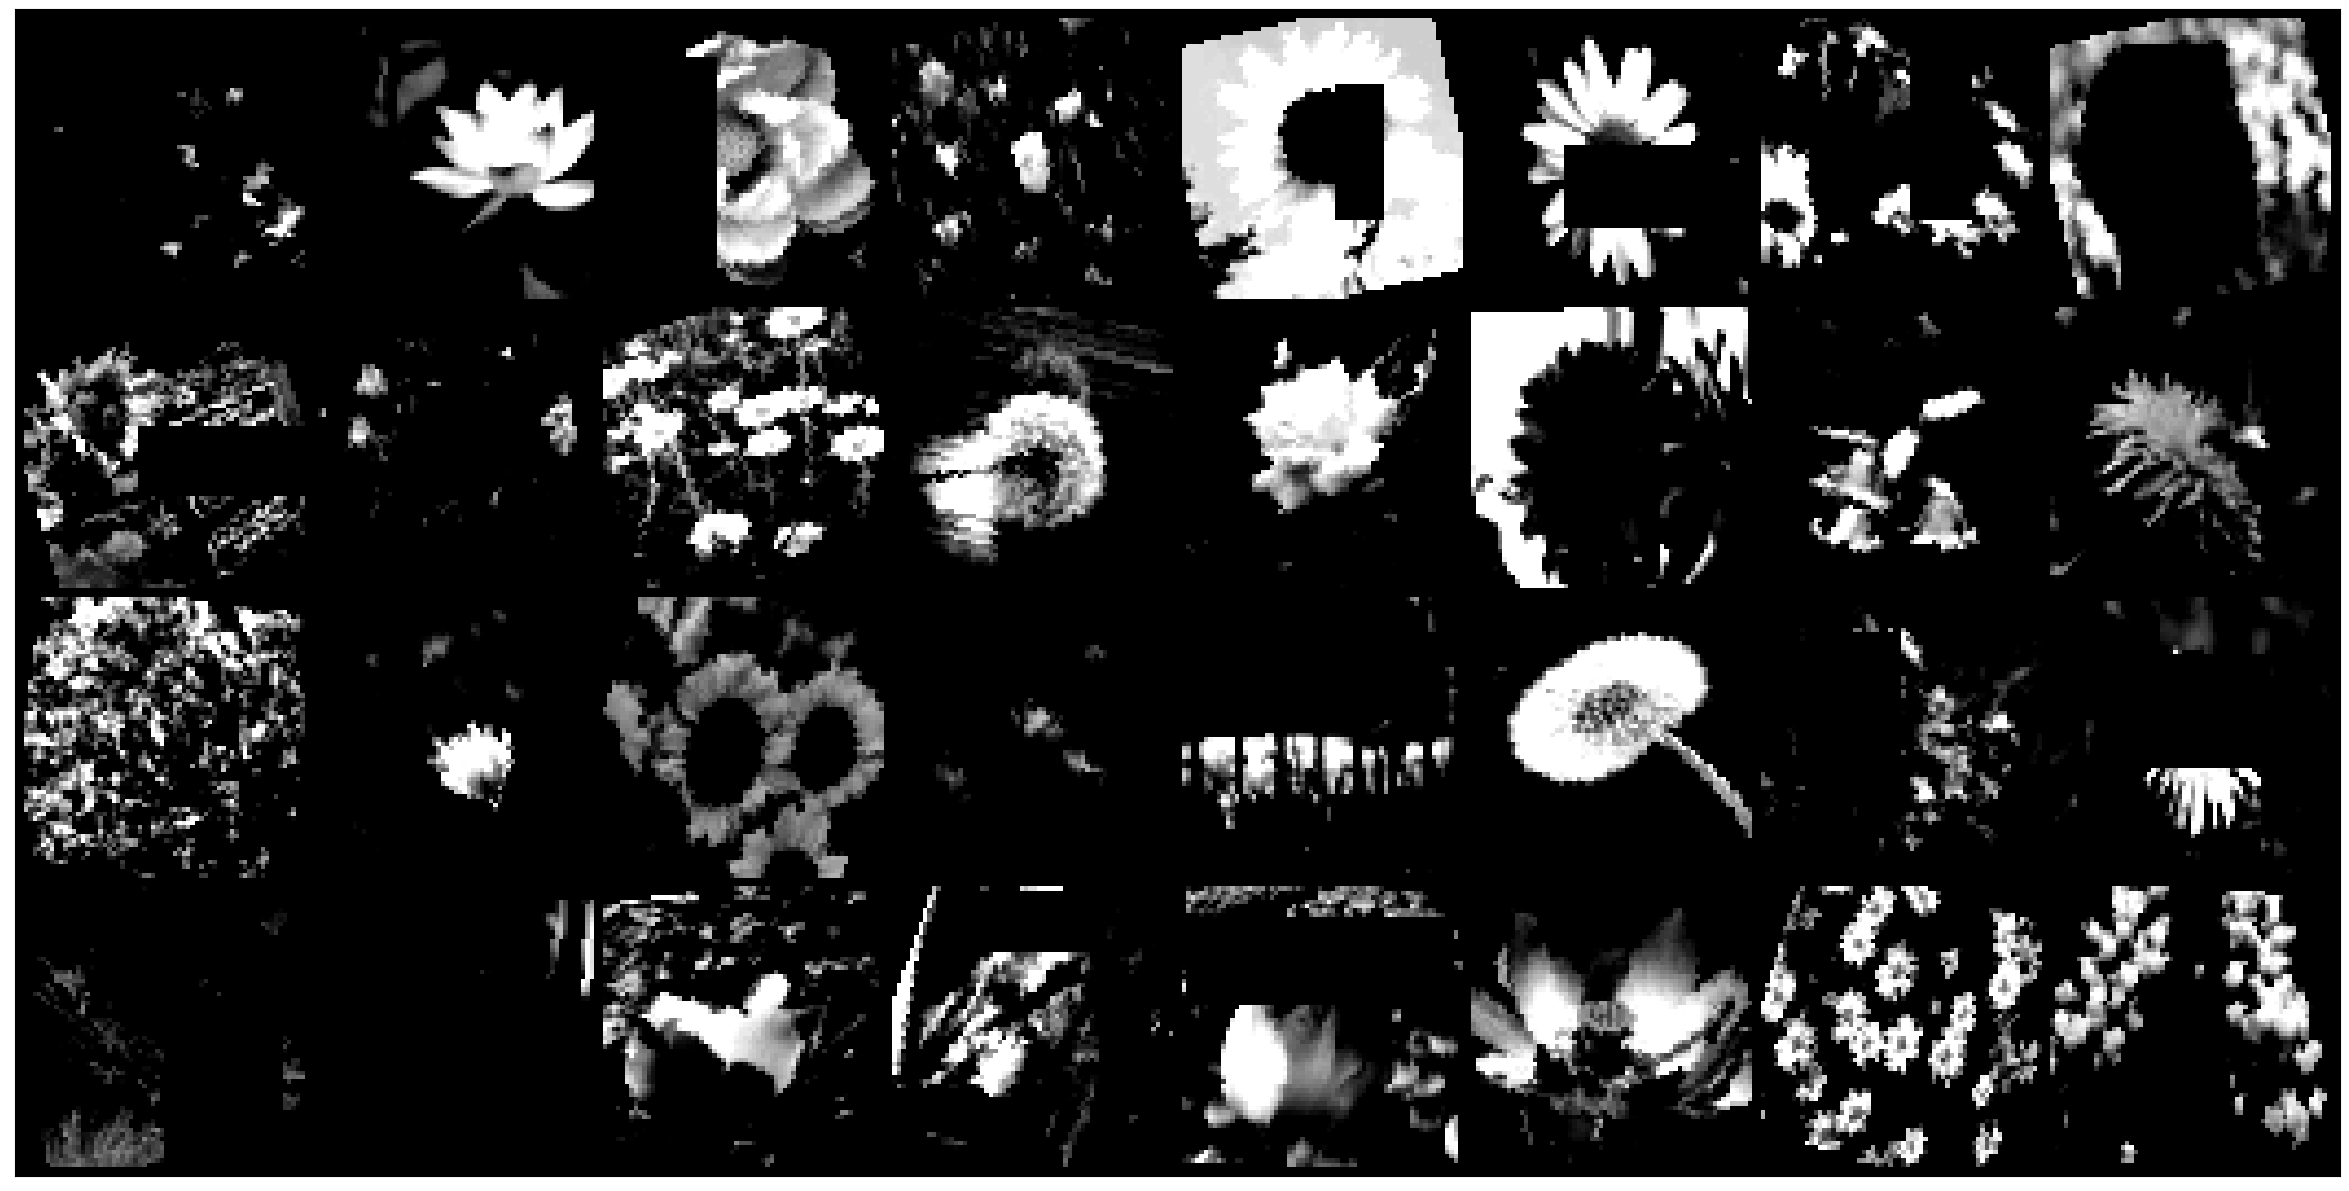

In [17]:
show_batch(train_dl) 

# Preparing Model 

Here we are creating our MLP class, while doing this, we make the size of the photo we will give, the hidden sizes and how many outpu sizes, which type of activation function will be used as parameters. We give hidden sizes as array, output size as integer and activation type as string.

In [19]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_type):
        super(MLP, self).__init__()
        
        # create a list of fully-connected layers
        self.fc_layers = nn.ModuleList()
        # add the first fully-connected layer
        self.fc_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # add the rest of the fully-connected layers
        for i in range(len(hidden_sizes) - 1):
            self.fc_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            
        # add the output layer
        self.fc_layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # create an instance of the specified activation function
        if activation_type == 'relu':
            self.activation = nn.ReLU()
        elif activation_type == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_type == 'tanh':
            self.activation = nn.Tanh()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i, fc in enumerate(self.fc_layers):
            x = fc(x)
            # apply the activation function after each fully-connected layer, except for the output layer
            if i < len(self.fc_layers) - 1:
                x = self.activation(x)
        return x

We create our first mlp model. The parameters in our first experiment are:

In [19]:

# define the model
input_size = img_size*img_size
str_size = str(img_size) +"x" + str(img_size) + "x" + str(1)
hidden_sizes = [64, 32, 16]
num_layers = len(hidden_sizes)
output_size = 7
num_epochs = 5
learning_rate = 0.001
activation_function = 'relu'
model = MLP(input_size, hidden_sizes, output_size, activation_function)

getting ready the device to run on gpu. and we are sending the model to device.

In [20]:
# define the device to use for training and testing
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# move the model to the device
model.to(device)

MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=4096, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=7, bias=True)
  )
  (activation): ReLU()
)

train and test functions for our mlp model

In [36]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss /= len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc


creating out criterion and optimizer. and lets make our first experiment. and save our model.

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
best_loss = float('inf')
best_acc = 0
# run the training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dl, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_dl, criterion, device)
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "modelxd.pt")
        best_acc = test_acc
    print(f'Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.2f}%, test_loss={test_loss:.4f}, test_acc={test_acc:.2f}%')


Epoch 1: train_loss=1.8144, train_acc=26.15%, test_loss=1.7837, test_acc=29.21%
Epoch 2: train_loss=1.7561, train_acc=29.81%, test_loss=1.8024, test_acc=28.21%
Epoch 3: train_loss=1.7345, train_acc=30.30%, test_loss=1.7665, test_acc=27.93%
Epoch 4: train_loss=1.7277, train_acc=31.16%, test_loss=1.7708, test_acc=30.64%
Epoch 5: train_loss=1.7160, train_acc=31.96%, test_loss=1.7676, test_acc=28.36%


Creating our data frame to store experiments

In [23]:
exp = pd.DataFrame(columns = ["Model" ,"Input Size ", "Activation Func.","Layer Size","Hidden Layer Sizes","Learning Rate","Batch Size","Epoch","Accuracy"])

append first experiment

In [24]:
exp.loc[len(exp.index)] = ["MLP",str_size, activation_function, num_layers , hidden_sizes,learning_rate, batch_size, num_epochs, best_acc] 
exp

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571


in this experiment, we cant say anything about the parameters effect yet. Because we didn't try anything else. But the result is like expected. So lets move on.

Create the function for more experiments

In [20]:
def MultiNeural(input_size,hidden_sizes,learning_rate,batch_size,num_epochs,activation_type):
    # DataLoaders for training and validation
    train_dl = DataLoader(trainx, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_dl = DataLoader(testx, batch_size,  shuffle=True ,num_workers=2, pin_memory=True)
    model = MLP(input_size, hidden_sizes, output_size,activation_type)
    # define the device to use for training and testing
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_layers = len(hidden_sizes)
    # move the model to the device
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    best_loss = float('inf')
    best_acc = 0
    # run the training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_dl, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_dl, criterion, device)
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), "modelxd.pt")
            best_acc = test_acc
        print(f'Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.2f}%, test_loss={test_loss:.4f}, test_acc={test_acc:.2f}%')
    exp.loc[len(exp.index)] = ["MLP",str_size, activation_type, num_layers , hidden_sizes,learning_rate, batch_size, num_epochs, best_acc] 

Lets change hidden sizes and use only 64 size 

In [26]:
# define the model
hidden_sizes = [64]
output_size = 7
num_epochs = 5
batch_size = 32
learning_rate = 0.001
activation_function = 'relu'
MultiNeural(input_size,hidden_sizes,learning_rate,batch_size,num_epochs,activation_function)
exp

Epoch 1: train_loss=1.9420, train_acc=25.57%, test_loss=2.0587, test_acc=27.57%
Epoch 2: train_loss=1.8146, train_acc=28.73%, test_loss=2.0361, test_acc=24.79%
Epoch 3: train_loss=1.7784, train_acc=29.50%, test_loss=1.8599, test_acc=28.29%
Epoch 4: train_loss=1.7537, train_acc=30.89%, test_loss=1.8601, test_acc=26.50%
Epoch 5: train_loss=1.7479, train_acc=30.94%, test_loss=1.8605, test_acc=29.21%


,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714


result is a little bit better but lets say nothing yet.

Lets change hidden sizes and use 64 and 32 sizes 

In [27]:
# define the model
hidden_sizes = [64,32]
output_size = 7
num_epochs = 5
batch_size = 32
learning_rate = 0.001
activation_function = 'relu'
MultiNeural(input_size,hidden_sizes,learning_rate,batch_size,num_epochs,activation_function)
exp

Epoch 1: train_loss=1.8199, train_acc=26.66%, test_loss=1.7938, test_acc=28.50%
Epoch 2: train_loss=1.7673, train_acc=28.56%, test_loss=1.8034, test_acc=28.57%
Epoch 3: train_loss=1.7451, train_acc=30.17%, test_loss=1.7715, test_acc=27.14%
Epoch 4: train_loss=1.7272, train_acc=31.64%, test_loss=1.7748, test_acc=26.93%
Epoch 5: train_loss=1.7192, train_acc=31.86%, test_loss=1.7585, test_acc=29.93%


,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571


it looks 64,32 option is quite well. 

lets change learning rate to 0.005 and hidden sizes to old version 

In [28]:
# define the model
hidden_sizes = [64,32,16]
output_size = 7
num_epochs = 5
batch_size = 32
learning_rate = 0.005
activation_function = 'relu'
MultiNeural(input_size,hidden_sizes,learning_rate,batch_size,num_epochs,activation_function)
exp

Epoch 1: train_loss=1.8557, train_acc=22.86%, test_loss=1.8114, test_acc=27.93%
Epoch 2: train_loss=1.8104, train_acc=26.15%, test_loss=1.7937, test_acc=26.93%
Epoch 3: train_loss=1.8048, train_acc=25.76%, test_loss=1.7894, test_acc=26.50%
Epoch 4: train_loss=1.7905, train_acc=26.67%, test_loss=1.7811, test_acc=28.86%
Epoch 5: train_loss=1.7750, train_acc=28.73%, test_loss=1.7677, test_acc=28.79%


,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714


it looks like the accuracy not much changed so lets try 0.01 

lets change learning rate to 0.01

In [29]:
# define the model
hidden_sizes = [64,32,16]
output_size = 7
num_epochs = 5
batch_size = 32
learning_rate = 0.01
activation_function = 'relu'
MultiNeural(input_size,hidden_sizes,learning_rate,batch_size,num_epochs,activation_function)
exp

Epoch 1: train_loss=1.8942, train_acc=22.64%, test_loss=1.8084, test_acc=24.71%
Epoch 2: train_loss=1.8561, train_acc=22.52%, test_loss=1.8303, test_acc=24.29%
Epoch 3: train_loss=1.8717, train_acc=22.47%, test_loss=1.8349, test_acc=23.29%
Epoch 4: train_loss=1.9305, train_acc=16.48%, test_loss=1.9329, test_acc=14.79%
Epoch 5: train_loss=1.9131, train_acc=17.58%, test_loss=1.8525, test_acc=23.50%


,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286


it did so much worse lets take it back :D

lets change batch_size to 64

In [30]:
# define the model
hidden_sizes = [64,32,16]
output_size = 7
num_epochs = 5
batch_size = 64
learning_rate = 0.001
activation_function = 'relu'
MultiNeural(input_size,hidden_sizes,learning_rate,batch_size,num_epochs,activation_function)
exp

Epoch 1: train_loss=1.8286, train_acc=25.23%, test_loss=1.7515, test_acc=29.79%
Epoch 2: train_loss=1.7575, train_acc=28.87%, test_loss=1.7228, test_acc=31.79%
Epoch 3: train_loss=1.7383, train_acc=30.21%, test_loss=1.7408, test_acc=29.64%
Epoch 4: train_loss=1.7263, train_acc=30.94%, test_loss=1.7222, test_acc=31.14%
Epoch 5: train_loss=1.7175, train_acc=31.30%, test_loss=1.7566, test_acc=31.21%


,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857


our model is improving that is quite nice.

lets change batch_size to 128

In [31]:
# define the model
hidden_sizes = [64,32,16]
output_size = 7
num_epochs = 5
batch_size = 128
learning_rate = 0.001
activation_function = 'relu'
MultiNeural(input_size,hidden_sizes,learning_rate,batch_size,num_epochs,activation_function)
exp

Epoch 1: train_loss=1.8467, train_acc=25.03%, test_loss=1.7999, test_acc=27.43%
Epoch 2: train_loss=1.7703, train_acc=29.13%, test_loss=1.7560, test_acc=31.36%
Epoch 3: train_loss=1.7462, train_acc=30.61%, test_loss=1.7564, test_acc=30.64%
Epoch 4: train_loss=1.7305, train_acc=31.07%, test_loss=1.7254, test_acc=31.64%
Epoch 5: train_loss=1.7185, train_acc=31.10%, test_loss=1.7534, test_acc=29.71%


,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857


it didn't work well it looks 64 is just fine. lets take it back.

lets change activation function relu to sigmoid

In [32]:
# define the model
hidden_sizes = [64,32,16]
output_size = 7
num_epochs = 5
batch_size = 32
learning_rate = 0.001
activation_function = 'sigmoid'
MultiNeural(input_size,hidden_sizes,learning_rate,batch_size,num_epochs,activation_function)
exp

Epoch 1: train_loss=1.9172, train_acc=19.56%, test_loss=1.8649, test_acc=25.71%
Epoch 2: train_loss=1.8547, train_acc=25.11%, test_loss=1.8429, test_acc=25.21%
Epoch 3: train_loss=1.8313, train_acc=26.27%, test_loss=1.8293, test_acc=25.64%
Epoch 4: train_loss=1.8194, train_acc=27.07%, test_loss=1.8241, test_acc=27.00%
Epoch 5: train_loss=1.8117, train_acc=26.88%, test_loss=1.8212, test_acc=26.14%


,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857


sigmoid didn't work well as expected because this function optimized for binary classification.

lets change activation function sigmoid to tanh

In [33]:
# define the model
hidden_sizes = [64,32,16]
output_size = 7
num_epochs = 5
batch_size = 32
learning_rate = 0.001
activation_function = 'tanh'
MultiNeural(input_size,hidden_sizes,learning_rate,batch_size,num_epochs,activation_function)
exp

Epoch 1: train_loss=1.8322, train_acc=25.78%, test_loss=1.8107, test_acc=27.64%
Epoch 2: train_loss=1.7989, train_acc=28.06%, test_loss=1.8013, test_acc=28.29%
Epoch 3: train_loss=1.7851, train_acc=29.26%, test_loss=1.7951, test_acc=29.00%
Epoch 4: train_loss=1.7838, train_acc=28.88%, test_loss=1.8107, test_acc=27.71%
Epoch 5: train_loss=1.7787, train_acc=29.26%, test_loss=1.8252, test_acc=26.43%


,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000


tanh is a little better than sigmoid but still worse then the relu so lets go back to the relu.

wee saw that our model is worked better with 64,32 hidden size 0.001 learning rate and 64 batch size lets put them and increase the epoch to 20. Lets see we will get a good solution.

# increase epoch and use best parameters according to the table.

In [34]:
# define the model
hidden_sizes = [64,32,16]
output_size = 7
num_epochs = 20
batch_size = 64
learning_rate = 0.001
activation_function = 'relu'
MultiNeural(input_size,hidden_sizes,learning_rate,batch_size,num_epochs,activation_function)
exp

Epoch 1: train_loss=1.8190, train_acc=26.64%, test_loss=1.7819, test_acc=28.14%
Epoch 2: train_loss=1.7654, train_acc=29.73%, test_loss=1.7733, test_acc=28.86%
Epoch 3: train_loss=1.7375, train_acc=30.81%, test_loss=1.7617, test_acc=29.50%
Epoch 4: train_loss=1.7281, train_acc=31.38%, test_loss=1.7643, test_acc=30.21%
Epoch 5: train_loss=1.7115, train_acc=31.80%, test_loss=1.7592, test_acc=29.36%
Epoch 6: train_loss=1.7053, train_acc=32.57%, test_loss=1.7305, test_acc=32.14%
Epoch 7: train_loss=1.7023, train_acc=32.72%, test_loss=1.7605, test_acc=29.57%
Epoch 8: train_loss=1.6875, train_acc=33.30%, test_loss=1.7473, test_acc=30.79%
Epoch 9: train_loss=1.6722, train_acc=33.82%, test_loss=1.7610, test_acc=28.93%
Epoch 10: train_loss=1.6787, train_acc=33.73%, test_loss=1.7298, test_acc=31.36%
Epoch 11: train_loss=1.6686, train_acc=34.66%, test_loss=1.7457, test_acc=31.79%
Epoch 12: train_loss=1.6689, train_acc=34.22%, test_loss=1.7274, test_acc=30.57%
Epoch 13: train_loss=1.6543, train_ac

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


As it seems, according to the experiments we did, we reached the best result of our model. The result came as I was a little confused. In image classification, mlp method is very weak compared to cnn, so we will use cnn in the next stage of our experiment and we will see the development of the model together.

# CNN

lets make the same data process for cnn too

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
data_dir = "flowers"
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"
tflow = os.listdir(train_dir)
img_size = 64
batch_size = 32
main_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)), # 32x32
    transforms.ToTensor()    # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.ToTensor(),
    transforms.RandomErasing()      #randomly erasing pixels 
])

trainx = ImageFolder(train_dir, aug_transform)
testx = ImageFolder(test_dir, main_transform)
train_dl = DataLoader(trainx, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(testx, batch_size,  shuffle=True ,num_workers=2, pin_memory=True)


In [37]:
img, label = trainx[0]
print(img.shape, label)
sizex = (3,img_size,img_size)

torch.Size([3, 64, 64]) 0


In [26]:
from torch import flatten

Now we will write our cnn class, the logic is almost the same as mlp, but the calculation of the inputs and outputs is slightly different. We have to set our class so that it can work in different situations, so I set the code to give the hidden sizes as an array and the output size as an integer value to our class as a parameter. While doing this, since the inputs and outputs will change according to the sizes of the batch size and the hidden size, I edited my function accordingly and developed a formula: ((img_size//(2**(len(conv_layer_sizes)))**2)*conv_layer_sizes[-1 ]. This formula gives the size after flattening in the forward phase. I'm pooling on each conv layer so I have to reduce my size by the size of the conv layer.

In [21]:
class CNN(nn.Module):
    def __init__(self, conv_layer_sizes, output_size):
        super(CNN, self).__init__()
        self.conv_layer_sizes = conv_layer_sizes
        # Define the convolutional layers
        self.conv_layers = nn.ModuleList()
        for i, size in enumerate(conv_layer_sizes):
            if i == 0:
                self.conv_layers.append(nn.Conv2d(3, size, kernel_size=3, padding=1))
            else:
                self.conv_layers.append(nn.Conv2d(conv_layer_sizes[i-1], size, kernel_size=3, padding=1))

        # Define the max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Define the fully connected layer
        self.fc1 = nn.Linear(((img_size//(2**(len(conv_layer_sizes))))**2)*conv_layer_sizes[-1], 512)
        self.fc2 = nn.Linear(512, output_size)
    def forward(self, x):
        # Apply the convolutional layers and max pooling layer
        for conv in self.conv_layers:
            x = self.pool(F.relu(conv(x)))
        # Flatten the output for the fully connected layer
        x = flatten(x, 1)
        # Apply the fully connected layer and return the output
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


our cnn will look like this.

In [ ]:
c1 = cv2.imread('conv.jpeg')
# show the image, provide window name first
imshow('Conv Layers', c1,size = 32)

In [ ]:
lets make the first experiment together. values:

In [40]:
num_epochs = 5
input_size = (3, img_size, img_size)
hidden_size = [16]
learning_rate = 0.001
model = CNN(conv_layer_sizes = hidden_size, output_size =7)
model.to(device)

CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

same operations with mlp. the only difference is here our optimizer is a momentum value now. it changes the learning rate over time.

In [41]:
# We use Cross Entropy Loss as our loss function
criterion = nn.CrossEntropyLoss()

# For our gradient descent algorthim or Optimizer
# We use Stochastic Gradient Descent (SGD) with a learning rate of 0.001
# We set the momentum to be 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [42]:
# We loop over the traing dataset multiple times (each time is called an epoch)

# Create some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []

# Iterate for a specified number of epochs
for epoch in range(num_epochs):  
    print(f'Starting Epoch: {epoch+1}...')

    # We keep adding or accumulating our loss after each mini-batch in running_loss
    running_loss = 0.0

    # We iterate through our trainloader iterator
    # Each cycle is a minibatch
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # Move our data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear the gradients before training by setting to zero
        # Required for a fresh start
        optimizer.zero_grad()

        # Forward -> backprop + optimize
        outputs = model(inputs) # Forward Propagation 
        loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
        loss.backward() # Back propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients/weights

        # Print Training statistics - Epoch/Iterations/Loss/Accuracy
        running_loss += loss.item()
        if i % 50 == 49:    # show our loss every 50 mini-batches
            correct = 0 # Initialize our variable to hold the count for the correct predictions
            total = 0 # Initialize our variable to hold the count of the number of labels iterated

            # We don't need gradients for validation, so wrap in 
            # no_grad to save memory
            with torch.no_grad():
                # Iterate through the testloader iterator
                for data in test_dl:
                    images, labels = data
                    # Move our data to GPU
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # Foward propagate our test data batch through our model
                    outputs = model(images)

                     # Get predictions from the maximum value of the predicted output tensor
                     # we set dim = 1 as it specifies the number of dimensions to reduce
                    _, predicted = torch.max(outputs.data, dim = 1)
                    # Keep adding the label size or length to the total variable
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Finished Training')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 1.927, Test Accuracy = 26.857%
Epoch: 1, Mini-Batches Completed: 100, Loss: 1.855, Test Accuracy = 32.214%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.772, Test Accuracy = 34.857%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.697, Test Accuracy = 34.714%
Epoch: 1, Mini-Batches Completed: 250, Loss: 1.645, Test Accuracy = 39.571%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.606, Test Accuracy = 42.929%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.572, Test Accuracy = 46.571%
Epoch: 2, Mini-Batches Completed: 100, Loss: 1.538, Test Accuracy = 45.357%
Epoch: 2, Mini-Batches Completed: 150, Loss: 1.504, Test Accuracy = 46.500%
Epoch: 2, Mini-Batches Completed: 200, Loss: 1.507, Test Accuracy = 48.929%
Epoch: 2, Mini-Batches Completed: 250, Loss: 1.428, Test Accuracy = 47.429%
Epoch: 2, Mini-Batches Completed: 300, Loss: 1.426, Test Accuracy = 47.786%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Comp

In [43]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

lets calculate our accuracy with last version of our model.

In [44]:
correct = 0 
total = 0

with torch.no_grad():
    for data in test_dl:
        images, labels = data
        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.3}%')

Accuracy of the network on the 10000 test images: 57.7%


it is much better than the mlp but we will increase this much much more trust me.

lets plot our loss and accuracy graphs according to epochs.

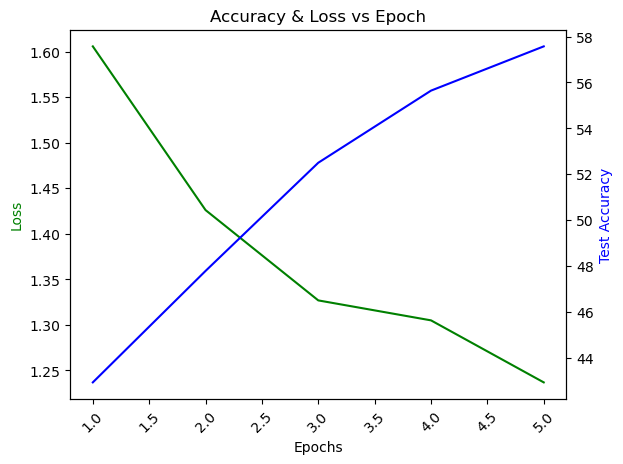

In [45]:
# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

Accuracy is increasing gradually. We need to increase the number of epochs here, but first we will do other trials and find the optimal values.

In [46]:
exp.loc[len(exp.index)] = ["CNN",str(img_size) + "x" + str(img_size) +"x"+ str(3), "Relu", len(hidden_size) , hidden_size, learning_rate, batch_size, num_epochs, accuracy] 

In [47]:
exp

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


# lets create a function to speed up

In [22]:
def Convolutional(batch_size,hidden_size,learning_rate,num_epochs, output_sizex):
    
    train_dl = DataLoader(trainx, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_dl = DataLoader(testx, batch_size,  shuffle=True ,num_workers=2, pin_memory=True)
    
    model = CNN(conv_layer_sizes = hidden_size, output_size = output_sizex)
    model.to(device)

    # We use Cross Entropy Loss as our loss function
    criterion = nn.CrossEntropyLoss()

    # For our gradient descent algorthim or Optimizer
    # We use Stochastic Gradient Descent (SGD) with a learning rate of 0.001
    # We set the momentum to be 0.9
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Create some empty arrays to store logs 
    epoch_log = []
    loss_log = []
    accuracy_log = []

    # Iterate for a specified number of epochs
    for epoch in range(num_epochs):  
        print(f'Starting Epoch: {epoch+1}...')

        # We keep adding or accumulating our loss after each mini-batch in running_loss
        running_loss = 0.0

        # We iterate through our trainloader iterator
        # Each cycle is a minibatch
        for i, data in enumerate(train_dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move our data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clear the gradients before training by setting to zero
            # Required for a fresh start
            optimizer.zero_grad()

            # Forward -> backprop + optimize
            outputs = model(inputs) # Forward Propagation 

            loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
            loss.backward() # Back propagate to obtain the new gradients for all nodes
            optimizer.step() # Update the gradients/weights

            # Print Training statistics - Epoch/Iterations/Loss/Accuracy
            running_loss += loss.item()
            if i % 50 == 49:    # show our loss every 50 mini-batches
                correct = 0 # Initialize our variable to hold the count for the correct predictions
                total = 0 # Initialize our variable to hold the count of the number of labels iterated

                # We don't need gradients for validation, so wrap in 
                # no_grad to save memory
                with torch.no_grad():
                    # Iterate through the testloader iterator
                    for data in test_dl:
                        images, labels = data
                        # Move our data to GPU
                        images = images.to(device)
                        labels = labels.to(device)

                        # Foward propagate our test data batch through our model
                        outputs = model(images)

                         # Get predictions from the maximum value of the predicted output tensor
                         # we set dim = 1 as it specifies the number of dimensions to reduce
                        _, predicted = torch.max(outputs.data, dim = 1)
                        # Keep adding the label size or length to the total variable
                        total += labels.size(0)
                        # Keep a running total of the number of predictions predicted correctly
                        correct += (predicted == labels).sum().item()

                    accuracy = 100 * correct / total
                    epoch_num = epoch + 1
                    actual_loss = running_loss / 50
                    print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                    running_loss = 0.0

        # Store training stats after each epoch
        epoch_log.append(epoch_num)
        loss_log.append(actual_loss)
        accuracy_log.append(accuracy)

    correct = 0 
    total = 0

    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            # Move our data to GPU
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    exp.loc[len(exp.index)] = ["CNN",str(img_size) + "x" + str(img_size) +"x"+ str(3), "Relu", len(hidden_size) , hidden_size, learning_rate, batch_size, num_epochs, accuracy] 

lets increase the number of hidden sizes to 2 = 16,32

In [51]:
hidden_size = [16,32]
learning_rate = 0.001
num_epochs = 5
batch_size = 32
output_size = 7
Convolutional(batch_size,hidden_size,learning_rate,num_epochs,output_size)
exp

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 1.945, Test Accuracy = 16.143%
Epoch: 1, Mini-Batches Completed: 100, Loss: 1.942, Test Accuracy = 17.071%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.938, Test Accuracy = 27.429%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.930, Test Accuracy = 23.143%
Epoch: 1, Mini-Batches Completed: 250, Loss: 1.918, Test Accuracy = 24.143%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.903, Test Accuracy = 31.357%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.861, Test Accuracy = 32.571%
Epoch: 2, Mini-Batches Completed: 100, Loss: 1.813, Test Accuracy = 31.786%
Epoch: 2, Mini-Batches Completed: 150, Loss: 1.764, Test Accuracy = 31.000%
Epoch: 2, Mini-Batches Completed: 200, Loss: 1.708, Test Accuracy = 36.857%
Epoch: 2, Mini-Batches Completed: 250, Loss: 1.670, Test Accuracy = 37.071%
Epoch: 2, Mini-Batches Completed: 300, Loss: 1.661, Test Accuracy = 39.500%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Comp

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


it didn't make much difference.

lets increase the number of hidden sizes to 3 16,32,64

In [52]:
hidden_size = [16,32,64]
learning_rate = 0.001
num_epochs = 5
batch_size = 32

Convolutional(batch_size,hidden_size,learning_rate,num_epochs,output_size)
exp

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 1.947, Test Accuracy = 16.286%
Epoch: 1, Mini-Batches Completed: 100, Loss: 1.946, Test Accuracy = 13.857%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.946, Test Accuracy = 17.786%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.944, Test Accuracy = 14.571%
Epoch: 1, Mini-Batches Completed: 250, Loss: 1.944, Test Accuracy = 14.286%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.944, Test Accuracy = 25.714%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.943, Test Accuracy = 23.429%
Epoch: 2, Mini-Batches Completed: 100, Loss: 1.943, Test Accuracy = 25.286%
Epoch: 2, Mini-Batches Completed: 150, Loss: 1.943, Test Accuracy = 24.429%
Epoch: 2, Mini-Batches Completed: 200, Loss: 1.941, Test Accuracy = 26.571%
Epoch: 2, Mini-Batches Completed: 250, Loss: 1.941, Test Accuracy = 20.786%
Epoch: 2, Mini-Batches Completed: 300, Loss: 1.939, Test Accuracy = 28.143%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Comp

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


wow i didn't expect that lets take it back and continue with 16,32

lets increase the learning rate to 0.005 

In [54]:
hidden_size = [16,32]
learning_rate = 0.005
num_epochs = 5
batch_size = 32

Convolutional(batch_size,hidden_size,learning_rate,num_epochs,output_size)
exp

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 1.939, Test Accuracy = 16.000%
Epoch: 1, Mini-Batches Completed: 100, Loss: 1.899, Test Accuracy = 26.571%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.815, Test Accuracy = 30.714%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.695, Test Accuracy = 40.857%
Epoch: 1, Mini-Batches Completed: 250, Loss: 1.594, Test Accuracy = 42.071%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.473, Test Accuracy = 50.214%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.393, Test Accuracy = 54.214%
Epoch: 2, Mini-Batches Completed: 100, Loss: 1.336, Test Accuracy = 53.571%
Epoch: 2, Mini-Batches Completed: 150, Loss: 1.292, Test Accuracy = 57.214%
Epoch: 2, Mini-Batches Completed: 200, Loss: 1.272, Test Accuracy = 53.857%
Epoch: 2, Mini-Batches Completed: 250, Loss: 1.230, Test Accuracy = 60.143%
Epoch: 2, Mini-Batches Completed: 300, Loss: 1.194, Test Accuracy = 56.643%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Comp

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


it did so much well lets keep increase until it gets worse.

lets increase the learning rate to 0.01

In [55]:
hidden_size = [16,32]
learning_rate = 0.01
num_epochs = 5
batch_size = 32

Convolutional(batch_size,hidden_size,learning_rate,num_epochs,output_size)
exp

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 1.938, Test Accuracy = 22.429%
Epoch: 1, Mini-Batches Completed: 100, Loss: 1.824, Test Accuracy = 28.286%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.645, Test Accuracy = 44.500%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.488, Test Accuracy = 47.714%
Epoch: 1, Mini-Batches Completed: 250, Loss: 1.373, Test Accuracy = 47.857%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.427, Test Accuracy = 47.500%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.356, Test Accuracy = 46.857%
Epoch: 2, Mini-Batches Completed: 100, Loss: 1.264, Test Accuracy = 53.214%
Epoch: 2, Mini-Batches Completed: 150, Loss: 1.247, Test Accuracy = 56.286%
Epoch: 2, Mini-Batches Completed: 200, Loss: 1.236, Test Accuracy = 58.857%
Epoch: 2, Mini-Batches Completed: 250, Loss: 1.173, Test Accuracy = 57.286%
Epoch: 2, Mini-Batches Completed: 300, Loss: 1.171, Test Accuracy = 57.429%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Comp

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


it looks just fine now. we can skip it the value as 0.01

lets increase the batch_size to 64

In [57]:
hidden_size = [16,32]
learning_rate = 0.01
num_epochs = 5
batch_size = 64

Convolutional(batch_size,hidden_size,learning_rate,num_epochs,output_size)
exp

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 1.895, Test Accuracy = 31.571%
Epoch: 1, Mini-Batches Completed: 100, Loss: 1.666, Test Accuracy = 45.286%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.411, Test Accuracy = 52.143%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.329, Test Accuracy = 53.500%
Epoch: 2, Mini-Batches Completed: 100, Loss: 1.249, Test Accuracy = 57.071%
Epoch: 2, Mini-Batches Completed: 150, Loss: 1.235, Test Accuracy = 59.429%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Completed: 50, Loss: 1.173, Test Accuracy = 60.714%
Epoch: 3, Mini-Batches Completed: 100, Loss: 1.108, Test Accuracy = 63.214%
Epoch: 3, Mini-Batches Completed: 150, Loss: 1.097, Test Accuracy = 63.357%
Starting Epoch: 4...
Epoch: 4, Mini-Batches Completed: 50, Loss: 1.100, Test Accuracy = 61.429%
Epoch: 4, Mini-Batches Completed: 100, Loss: 1.079, Test Accuracy = 60.714%
Epoch: 4, Mini-Batches Completed: 150, Loss: 1.064, Test Accuracy = 64.143%
Starting

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


it did worse. 

lets increase the batch_size to 128

In [58]:
hidden_size = [16,32]
learning_rate = 0.001
num_epochs = 5
batch_size = 128

Convolutional(batch_size,hidden_size,learning_rate,num_epochs,output_size)
exp

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 1.945, Test Accuracy = 19.143%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.939, Test Accuracy = 24.643%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Completed: 50, Loss: 1.931, Test Accuracy = 24.000%
Starting Epoch: 4...
Epoch: 4, Mini-Batches Completed: 50, Loss: 1.917, Test Accuracy = 31.214%
Starting Epoch: 5...
Epoch: 5, Mini-Batches Completed: 50, Loss: 1.886, Test Accuracy = 31.071%


,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


it did much much worse lets take it back.

i wonder if i keep increasing the learning rate, will it work lets try one more time.

In [59]:
hidden_size = [16,32]
learning_rate = 0.02
num_epochs = 5
batch_size = 32

Convolutional(batch_size,hidden_size,learning_rate,num_epochs,output_size)
exp

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 1.890, Test Accuracy = 31.286%
Epoch: 1, Mini-Batches Completed: 100, Loss: 1.742, Test Accuracy = 35.786%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.561, Test Accuracy = 42.143%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.412, Test Accuracy = 53.000%
Epoch: 1, Mini-Batches Completed: 250, Loss: 1.381, Test Accuracy = 49.643%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.330, Test Accuracy = 47.929%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.250, Test Accuracy = 55.571%
Epoch: 2, Mini-Batches Completed: 100, Loss: 1.282, Test Accuracy = 53.429%
Epoch: 2, Mini-Batches Completed: 150, Loss: 1.235, Test Accuracy = 48.429%
Epoch: 2, Mini-Batches Completed: 200, Loss: 1.238, Test Accuracy = 54.929%
Epoch: 2, Mini-Batches Completed: 250, Loss: 1.249, Test Accuracy = 59.929%
Epoch: 2, Mini-Batches Completed: 300, Loss: 1.295, Test Accuracy = 57.000%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Comp

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


it didn't make much a difference with 0.01 so lets stuck with the 0.01.

# nice

# lets try with the best options 20 epoch

In [60]:
hidden_size = [16,32]
learning_rate = 0.01
num_epochs = 20
batch_size = 32

Convolutional(batch_size,hidden_size,learning_rate,num_epochs,output_size)
exp

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 1.907, Test Accuracy = 25.286%
Epoch: 1, Mini-Batches Completed: 100, Loss: 1.703, Test Accuracy = 41.500%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.457, Test Accuracy = 46.286%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.404, Test Accuracy = 53.643%
Epoch: 1, Mini-Batches Completed: 250, Loss: 1.319, Test Accuracy = 53.929%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.282, Test Accuracy = 56.857%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.224, Test Accuracy = 57.500%
Epoch: 2, Mini-Batches Completed: 100, Loss: 1.220, Test Accuracy = 59.643%
Epoch: 2, Mini-Batches Completed: 150, Loss: 1.216, Test Accuracy = 60.286%
Epoch: 2, Mini-Batches Completed: 200, Loss: 1.217, Test Accuracy = 56.857%
Epoch: 2, Mini-Batches Completed: 250, Loss: 1.166, Test Accuracy = 60.429%
Epoch: 2, Mini-Batches Completed: 300, Loss: 1.140, Test Accuracy = 51.929%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Comp

Epoch: 18, Mini-Batches Completed: 100, Loss: 0.503, Test Accuracy = 77.143%
Epoch: 18, Mini-Batches Completed: 150, Loss: 0.545, Test Accuracy = 76.286%
Epoch: 18, Mini-Batches Completed: 200, Loss: 0.531, Test Accuracy = 76.214%
Epoch: 18, Mini-Batches Completed: 250, Loss: 0.489, Test Accuracy = 74.929%
Epoch: 18, Mini-Batches Completed: 300, Loss: 0.543, Test Accuracy = 77.214%
Starting Epoch: 19...
Epoch: 19, Mini-Batches Completed: 50, Loss: 0.478, Test Accuracy = 77.571%
Epoch: 19, Mini-Batches Completed: 100, Loss: 0.457, Test Accuracy = 75.286%
Epoch: 19, Mini-Batches Completed: 150, Loss: 0.506, Test Accuracy = 76.357%
Epoch: 19, Mini-Batches Completed: 200, Loss: 0.512, Test Accuracy = 76.714%
Epoch: 19, Mini-Batches Completed: 250, Loss: 0.507, Test Accuracy = 77.071%
Epoch: 19, Mini-Batches Completed: 300, Loss: 0.476, Test Accuracy = 77.357%
Starting Epoch: 20...
Epoch: 20, Mini-Batches Completed: 50, Loss: 0.450, Test Accuracy = 78.071%
Epoch: 20, Mini-Batches Completed:

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


now our accuracy looks like something.

In [ ]:
lets increase the hidden sizes this will take some time but i believe it will worth.

In [61]:
hidden_size = [128,256]
learning_rate = 0.01
num_epochs = 20
batch_size = 32

Convolutional(batch_size,hidden_size,learning_rate,num_epochs,output_size)
exp

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 1.845, Test Accuracy = 32.929%
Epoch: 1, Mini-Batches Completed: 100, Loss: 1.563, Test Accuracy = 48.714%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.377, Test Accuracy = 53.929%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.273, Test Accuracy = 55.000%
Epoch: 1, Mini-Batches Completed: 250, Loss: 1.248, Test Accuracy = 57.714%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.281, Test Accuracy = 60.000%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.250, Test Accuracy = 58.500%
Epoch: 2, Mini-Batches Completed: 100, Loss: 1.150, Test Accuracy = 62.643%
Epoch: 2, Mini-Batches Completed: 150, Loss: 1.188, Test Accuracy = 53.857%
Epoch: 2, Mini-Batches Completed: 200, Loss: 1.105, Test Accuracy = 63.857%
Epoch: 2, Mini-Batches Completed: 250, Loss: 1.137, Test Accuracy = 62.357%
Epoch: 2, Mini-Batches Completed: 300, Loss: 1.081, Test Accuracy = 65.214%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Comp

Epoch: 18, Mini-Batches Completed: 100, Loss: 0.361, Test Accuracy = 82.000%
Epoch: 18, Mini-Batches Completed: 150, Loss: 0.354, Test Accuracy = 79.143%
Epoch: 18, Mini-Batches Completed: 200, Loss: 0.405, Test Accuracy = 80.643%
Epoch: 18, Mini-Batches Completed: 250, Loss: 0.354, Test Accuracy = 82.214%
Epoch: 18, Mini-Batches Completed: 300, Loss: 0.414, Test Accuracy = 80.571%
Starting Epoch: 19...
Epoch: 19, Mini-Batches Completed: 50, Loss: 0.363, Test Accuracy = 81.786%
Epoch: 19, Mini-Batches Completed: 100, Loss: 0.350, Test Accuracy = 80.643%
Epoch: 19, Mini-Batches Completed: 150, Loss: 0.345, Test Accuracy = 81.071%
Epoch: 19, Mini-Batches Completed: 200, Loss: 0.378, Test Accuracy = 79.929%
Epoch: 19, Mini-Batches Completed: 250, Loss: 0.397, Test Accuracy = 81.786%
Epoch: 19, Mini-Batches Completed: 300, Loss: 0.341, Test Accuracy = 82.000%
Starting Epoch: 20...
Epoch: 20, Mini-Batches Completed: 50, Loss: 0.339, Test Accuracy = 80.857%
Epoch: 20, Mini-Batches Completed:

,Model,Input Size,Activation Func.,Layer Size,Hidden Layer Sizes,Learning Rate,Batch Size,Epoch,Accuracy
0,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,32,5,27.928571
1,MLP,64x64x1,relu,1,[64],0.001,32,5,28.285714
2,MLP,64x64x1,relu,2,"[64, 32]",0.001,32,5,29.928571
3,MLP,64x64x1,relu,3,"[64, 32, 16]",0.005,32,5,28.785714
4,MLP,64x64x1,relu,3,"[64, 32, 16]",0.010,32,5,24.714286
5,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,5,31.142857
6,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,128,5,31.642857
7,MLP,64x64x1,sigmoid,3,"[64, 32, 16]",0.001,32,5,26.142857
8,MLP,64x64x1,tanh,3,"[64, 32, 16]",0.001,32,5,29.000000
9,MLP,64x64x1,relu,3,"[64, 32, 16]",0.001,64,20,32.428571


Finally we did reach the common ground. With the %81 accuracy with the 7 output size i can say that this model really works well.

# Report and Conclusion

We ran both mlp and cnn codes with different values and activation functions and listed the results. As can be seen from the results, cnn performed much better than mlp. In order to avoid overfitting, we rotated our photos left and right, and deleted random pixels. and we prevented him from memorizing the train. We used the relu function in general for mlp and cnn as the activation function. but tried the others too. As the number of hidden layers increased, our model became more complex some times it is well some times it is not. As the learning rate increased, it started to give worse results for mlp. But in CNN it did well with the increasing. As the default parameter, 0.001 gave the best results in our case for MLP. 0.01 gave the best result in our case for CNN. Learning rate parameter could be a problem (too big - may not converge, too small - very slow convergence). For this reason I defined a learning rate decay parameter for CNN model. After each epoch model
reduce the learning rate by multiplying it by a decay rate. As the batch size increased, our functions ran faster, but we can say that we achieved better results with small batch sizes (16,32). As the number of epochs increased, our models gave better results. Because more epoch means more training. We observed better results when we used functions that adjusted the learning rate according to the situation.